In [11]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import pandas as pd
import numpy as np
import sys
sys.path.append('../../sli')
from utils import make_performance_uncertainty_plot, cross_entropy
from utils import get_weight_tensor_from_class_weights, train, plot_calibration_curve, make_precision_accuracy_plot
from utils import NN

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [12]:
X_train = pd.read_csv('../../data/MIMIC/X_train_processed.csv')
y_train = pd.read_csv('../../data/MIMIC/y_train.csv')

X_test = pd.read_csv('../../data/MIMIC/X_test_processed.csv')
y_test = pd.read_csv('../../data/MIMIC/y_test.csv')

In [13]:
data = torch.from_numpy(X_train.values).float()
target = torch.from_numpy(y_train.values).float()

data_val = torch.from_numpy(X_test.values).float()
target_val = torch.from_numpy(y_test.values).float()

In [15]:
np.random.seed(13)
torch.manual_seed(13)

In [ ]:
canonical = NN(quantiles=[0.5])
optimizer = torch.optim.Adam(canonical.parameters(), lr=1e-2)
canonical = train(canonical, data, target, data_val,
                 target_val, optimizer, quantiles=[0.5])

In [17]:
overconfident = NN(quantiles=[0.4])

overconfident.z = canonical.z
overconfident.z.weight.requires_grad = False
overconfident.z.bias.requires_grad = False

optimizer = torch.optim.Adam(overconfident.parameters(), lr=1e-2)

overconfident = train(overconfident, data, target, 
             data_val, target_val, optimizer, quantiles=[0.4])

Validation loss: 0.27, Train loss: 0.33
Validation loss: 0.19, Train loss: 0.20
Validation loss: 0.14, Train loss: 0.12
Validation loss: 0.13, Train loss: 0.10
Validation loss: 0.10, Train loss: 0.10
Validation loss: 0.10, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09


In [18]:
underconfident = NN(quantiles=[0.6])

underconfident.z = canonical.z
underconfident.z.weight.requires_grad = False
underconfident.z.bias.requires_grad = False

optimizer = torch.optim.Adam(underconfident.parameters(), lr=1e-2)

underconfident = train(underconfident, data, target, 
             data_val, target_val, optimizer, [0.6])

Validation loss: 0.36, Train loss: 0.41
Validation loss: 0.23, Train loss: 0.25
Validation loss: 0.12, Train loss: 0.11
Validation loss: 0.11, Train loss: 0.09
Validation loss: 0.10, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08


In [59]:
outputs_val = [underconfident(data_val)[0], canonical(data_val)[0], overconfident(data_val)[0]]

In [60]:
outputs = [torch.sigmoid(output) for output in outputs_val]

In [61]:
plots = []

for output in outputs:
    plots.append(plot_calibration_curve(y_test, output.detach().numpy()))

In [63]:
# for plot in plots:
#     plt.plot(plot[0], plot[1])
#     plt.plot(plot[0], plot[0])
    
# plt.show()

In [64]:
outputs_val = torch.stack([torch.sigmoid(output_val.squeeze()) for output_val in outputs_val], dim=1).detach().numpy().round(3)

In [65]:
# optimal cutoff point
cutoff = np.percentile(outputs_val[:, 1], 100 * (1-y_train.values.mean()))
print('optimal cutoff', cutoff)
preds = (outputs_val > cutoff)

optimal cutoff 0.2875570424273137


In [25]:
# make_precision_accuracy_plot(outputs_val, preds, y_test)

/system/linux/anaconda3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


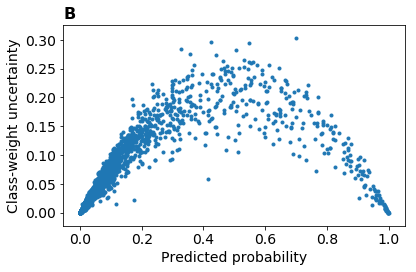

In [44]:
# uncertainties = np.std(outputs_val[:, 1:9], axis=-1)
# uncertainties = outputs_val[:, 1] - outputs_val[:, 9]
# uncertainties = outputs_val[:, 2] - outputs_val[:, 8]
# uncertainties = outputs_val[:, 3] - outputs_val[:, 7]
uncertainties = outputs_val[:, 2] - outputs_val[:, 0]

preds_50 = preds[:, 1]
# plt.scatter(outputs_val[:, 5][preds_50 == y_test.squeeze().values], uncertainties[preds_50 == y_test.squeeze().values], marker='.')
# plt.scatter(outputs_val[:, 5][preds_50 != y_test.squeeze().values], uncertainties[preds_50 != y_test.squeeze().values], marker='.')
plt.scatter(outputs_val[:, 1], uncertainties, marker='.')
plt.xlabel('Predicted probability')
plt.ylabel('Class-weight uncertainty')
plt.title('B', loc='left', fontweight="bold", fontsize=16)
plt.tight_layout()
plt.savefig('fig_mimic_scatter.pdf')


In [66]:
y_true = y_test.values.squeeze(-1)
y_prob = outputs_val[:, 1]
y_unc = uncertainties

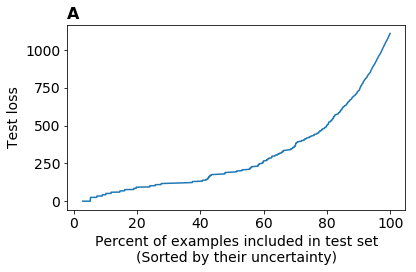

In [45]:
make_performance_uncertainty_plot(y_true, y_prob, y_unc, 'Loss', performance_fn_args={'reduction': 'sum'})
plt.title('A', loc='left', fontweight="bold", fontsize=16)
plt.ylabel('Test loss')
plt.xlabel('Percent of examples included in test set\n(Sorted by their uncertainty)')
plt.tight_layout()
plt.savefig('fig_mimic_cumloss.pdf')

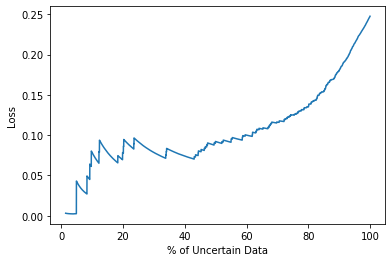

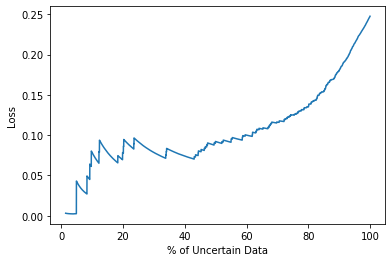

In [18]:
make_performance_uncertainty_plot(y_true, y_prob, y_unc, 'Loss', performance_fn_args={'reduction': 'mean'})

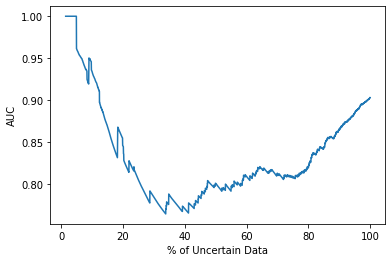

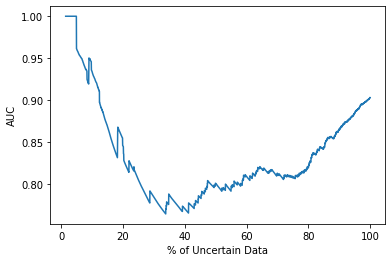

In [19]:
make_performance_uncertainty_plot(y_true, y_prob, uncertainties, 'AUC', performance_fn=roc_auc_score)

In [20]:
from utils import loss_at_50

In [21]:
loss_at_50(y_true, y_prob, uncertainties)

206.03209908562712

In [22]:
cross_entropy(y_true, y_prob, reduction='sum')

1109.4104833218735

In [23]:
false_predictions = preds_50 != y_test.squeeze()

In [24]:
roc_auc_score(false_predictions, uncertainties)

0.8605188499542024

In [25]:
average_precision_score(false_predictions, uncertainties)

0.34688499069820466

## Asymmetric entropy baseline

In [26]:
def asymmetric_entropy(p, w):
    return (p * (1 - p)) / ((-2 * w + 1) * p + w ** 2)


In [27]:
# uncertainties = asymmetric_entropy(outputs_val[:, 5], y_train.values.mean())
uncertainties = asymmetric_entropy(outputs_val[:, 1], cutoff)
# ouputs_val(n x 3)(underconfident, canon, over)

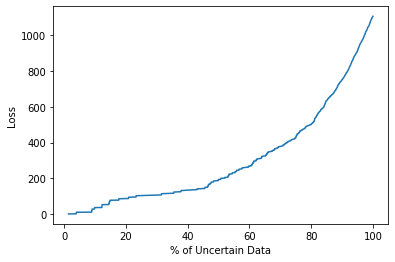

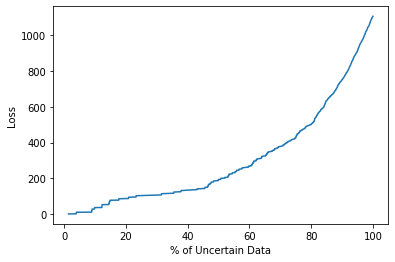

In [28]:
make_performance_uncertainty_plot(y_true, y_prob, uncertainties, 'Loss', performance_fn_args={'reduction': 'sum'})

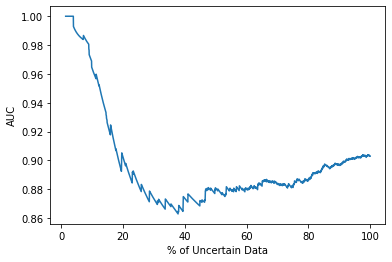

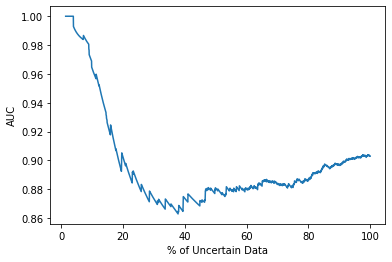

In [29]:
make_performance_uncertainty_plot(y_true, y_prob, uncertainties, 'AUC', performance_fn=roc_auc_score)

In [30]:
loss_at_50(y_true, y_prob, uncertainties)

192.63878982583992

In [31]:
roc_auc_score(false_predictions, uncertainties)

0.8501167230017265

In [32]:
average_precision_score(false_predictions, uncertainties)

0.32740518067930735

# P/R

In [67]:
from sklearn.metrics import average_precision_score, precision_score, recall_score

In [68]:
for i in range(outputs_val.shape[1]):
    outputs = outputs_val[:, i]
    print(average_precision_score(target_val, outputs))

0.6662740617982323
0.6671950892698062
0.6648195596900268


In [69]:
# use optimal cutoff for canonical model
for i in range(preds.shape[1]):
    outputs = preds[:, i]
    
    print(f'prec {precision_score(target_val, outputs):0.2f}, rec {recall_score(target_val, outputs):0.2f}')

prec 0.70, rec 0.52
prec 0.63, rec 0.60
prec 0.54, rec 0.66


In [49]:
# this cutoff is the optimal cutoff for all 3 models separately
cutoff = np.percentile(outputs_val, 100 * (1 - y_train.values.mean()), axis=0)

In [50]:
preds = outputs_val > cutoff

In [51]:
for i in range(preds.shape[1]):
    outputs = preds[:, i]
    
    print(precision_score(target_val, outputs))
    print(recall_score(target_val, outputs))
    print('\n')

0.6329787234042553
0.6055979643765903


0.6303191489361702
0.6030534351145038


0.6276595744680851
0.6005089058524173




# make viz

In [139]:
X_test.shape

(4477, 44)

In [140]:
sys.path.append('../..')

In [148]:
data = X_train.values #[:, 1:]
feature_names = list(X_train.columns) #[1:]
feature_names = [n.replace('_', ' ') for n in feature_names]
models = [underconfident, canonical, overconfident]

In [149]:
x = data[1]

In [150]:
from functools import partial
# from scipy.special import softmax

In [152]:

def proba(x, f):
    x = torch.Tensor(x)
    if len(x.shape) == 1:
        x = x.unsqueeze(0)
    with torch.no_grad():
#         print('x shape', x.shape)
        out = torch.sigmoid(f(x)[0])
        out = torch.cat([1 - out, out], dim=1).numpy()
    return out

from sli import Explainer
explainer = Explainer(data, feature_names=feature_names)
explainer.calc_percentiles(partial(proba, f=models[0]),
                           partial(proba, f=models[1]),
                           partial(proba, f=models[2])
                          )
expl_dicts = [explainer.explain_instance(x, partial(proba, f=models[i]), return_table=False) for i in range(3)]
explainer.viz_expl(expl_dicts[1], [expl_dicts[0], expl_dicts[2]], 
                   show_stds=True, # display stddevs for the feature importances
                   point_id=None, # display id of this point
                   round=3, 
                   filename='out.html') # saves to fully-contained interactive html file

In [146]:
softmax(proba(x, models[0]))

array([[0.7305468 , 0.26945314]], dtype=float32)

In [123]:
len(x.shape)

1